## Objective
This notebook performs comprehensive feature analysis to understand our dataset's characteristics and select the most relevant features for our **apartment price prediction model**. We build upon the initial data exploration to make data-driven decisions about feature transformations, selection, and augmentation strategies.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import arabic_reshaper
from bidi.algorithm import get_display
from scipy import stats

plt.rcParams['font.family'] = ['Arial Unicode MS', 'Tahoma', 'Arial', 'sans-serif']

In [2]:
df = pd.read_csv("Apartments.csv", encoding = 'utf-8-sig')
df.head(10)

,السعر بالشيكل,المدينة,الحي / المنطقة,عدد الغرف,عدد الحمامات,مفروشة,مساحة البناء,الطابق,عمر البناء,العقار مرهون,طريقة الدفع,مصعد,موقف سيارات
0,"397,476",نابلس,المخفية,3,2,0,138,2,2,F,0,T,T
1,"400,000",رام الله والبيرة,الطيرة,3,2,0,105,3,0,F,0,F,F
2,"198,738",جنين,الجابريات,3,2,0,165,1,1,F,2,F,F
3,"1,780,608",بيت لحم,بيت ساحور,3,3,2,300,R,3,F,0,T,T
4,"530,000",رام الله والبيرة,الطيرة,3,3,0,185,2,3,F,0,T,T
5,"172,588",طولكرم,شويكة,3,2,0,125,3,2,F,2,T,T
6,"235,348",طولكرم,الحي الشرقي,3,1,0,120,1,4,F,2,F,F
7,"310,000",نابلس,الجبل الشمالي,3,2,0,155,1,2,F,0,F,F
8,"156,898",نابلس,ش. عمان,2,1,0,120,P,4,F,2,F,F
9,"550,000",القدس,كفر عقب,3,3,0,125,10,1,F,2,T,T


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 623 entries, 0 to 622
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   السعر بالشيكل   623 non-null    object
 1   المدينة         623 non-null    object
 2   الحي / المنطقة  623 non-null    object
 3   عدد الغرف       623 non-null    int64 
 4   عدد الحمامات    623 non-null    int64 
 5   مفروشة          623 non-null    int64 
 6   مساحة البناء    623 non-null    int64 
 7   الطابق          623 non-null    object
 8   عمر البناء      623 non-null    int64 
 9   العقار مرهون    623 non-null    object
 10  طريقة الدفع     623 non-null    int64 
 11  مصعد            623 non-null    object
 12  موقف سيارات     623 non-null    object
dtypes: int64(6), object(7)
memory usage: 63.4+ KB


In [4]:
# convert price to integer values
df['السعر بالشيكل'] = df["السعر بالشيكل"].astype(str).str.replace('"', '', regex=False).str.replace(",", "", regex=False)
df['السعر بالشيكل'] = pd.to_numeric(df['السعر بالشيكل'])
df.head(1)

,السعر بالشيكل,المدينة,الحي / المنطقة,عدد الغرف,عدد الحمامات,مفروشة,مساحة البناء,الطابق,عمر البناء,العقار مرهون,طريقة الدفع,مصعد,موقف سيارات
0,397476,نابلس,المخفية,3,2,0,138,2,2,F,0,T,T


In [5]:
# Map T/F to True/False boolean values
bool_map = {'T': True, 'F': False}
pd.set_option('future.no_silent_downcasting', True)
for col in ["العقار مرهون", "مصعد", "موقف سيارات"]:
    df[col] = df[col].replace({'T': True, 'F': False}).astype(bool)
df.head(1)

,السعر بالشيكل,المدينة,الحي / المنطقة,عدد الغرف,عدد الحمامات,مفروشة,مساحة البناء,الطابق,عمر البناء,العقار مرهون,طريقة الدفع,مصعد,موقف سيارات
0,397476,نابلس,المخفية,3,2,0,138,2,2,False,0,True,True


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 623 entries, 0 to 622
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   السعر بالشيكل   623 non-null    int64 
 1   المدينة         623 non-null    object
 2   الحي / المنطقة  623 non-null    object
 3   عدد الغرف       623 non-null    int64 
 4   عدد الحمامات    623 non-null    int64 
 5   مفروشة          623 non-null    int64 
 6   مساحة البناء    623 non-null    int64 
 7   الطابق          623 non-null    object
 8   عمر البناء      623 non-null    int64 
 9   العقار مرهون    623 non-null    bool  
 10  طريقة الدفع     623 non-null    int64 
 11  مصعد            623 non-null    bool  
 12  موقف سيارات     623 non-null    bool  
dtypes: bool(3), int64(7), object(3)
memory usage: 50.6+ KB


In [7]:
def process_arabic_text(text):
    if isinstance(text, str):
        reshaped_text = arabic_reshaper.reshape(text)
        return get_display(reshaped_text)
    return text

### Detecting Outliers in Price & Area

In [8]:
# Price
prices = df['السعر بالشيكل']
z_scores = np.abs(stats.zscore(prices))
outlier_mask = z_scores > 3
outlier_count = outlier_mask.sum()

print("\nZ-SCORE OUTLIER DETECTION")
print(f"Threshold: |z| > 3")
print("Outliers found:", outlier_count)

print("\nTop high price outliers:")
print(df[outlier_mask].sort_values('السعر بالشيكل', ascending=False)
      [["المدينة", "الحي / المنطقة", "مساحة البناء", 'السعر بالشيكل', "عدد الغرف"]]
      .head(10))
#drop outliers
df = df[~outlier_mask]


Z-SCORE OUTLIER DETECTION
Threshold: |z| > 3
Outliers found: 2

Top high price outliers:
              المدينة الحي / المنطقة  مساحة البناء  السعر بالشيكل  عدد الغرف
320  رام الله والبيرة        بيتونيا           160       37095996          3
345             القدس           حزما           142       10000000          3


In [9]:
# Area
areas = df["مساحة البناء"]
z_scores_area = np.abs(stats.zscore(areas))
outlier_mask_area = z_scores_area > 3
outlier_count_area = outlier_mask_area.sum()

print("\nZ-SCORE OUTLIER DETECTION — AREA")
print(f"Threshold: |z| > 3")
print("Outliers found:", outlier_count_area)

print("\nTop large area outliers:")
print(df[outlier_mask_area].sort_values("مساحة البناء", ascending=False)
      [["المدينة", "الحي / المنطقة", "مساحة البناء", "عدد الغرف", "السعر بالشيكل"]]
      .head(10))
#drop outliers
df = df[~outlier_mask_area]


Z-SCORE OUTLIER DETECTION — AREA
Threshold: |z| > 3
Outliers found: 6

Top large area outliers:
              المدينة الحي / المنطقة  مساحة البناء  عدد الغرف  السعر بالشيكل
423  رام الله والبيرة         الطيرة          1802          3         556440
417  رام الله والبيرة         الطيرة          1240          3        5007960
318  رام الله والبيرة        بير زيت          1000          3         593536
164  رام الله والبيرة       عين عريك           750          3         300000
446  رام الله والبيرة        بيتونيا           600          6         650000
356  رام الله والبيرة        بير زيت           500          5        1409648


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 615 entries, 0 to 622
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   السعر بالشيكل   615 non-null    int64 
 1   المدينة         615 non-null    object
 2   الحي / المنطقة  615 non-null    object
 3   عدد الغرف       615 non-null    int64 
 4   عدد الحمامات    615 non-null    int64 
 5   مفروشة          615 non-null    int64 
 6   مساحة البناء    615 non-null    int64 
 7   الطابق          615 non-null    object
 8   عمر البناء      615 non-null    int64 
 9   العقار مرهون    615 non-null    bool  
 10  طريقة الدفع     615 non-null    int64 
 11  مصعد            615 non-null    bool  
 12  موقف سيارات     615 non-null    bool  
dtypes: bool(3), int64(7), object(3)
memory usage: 54.7+ KB


### Skewness Check

📊 Skewness for Numeric Features:
مساحة البناء: 1.44


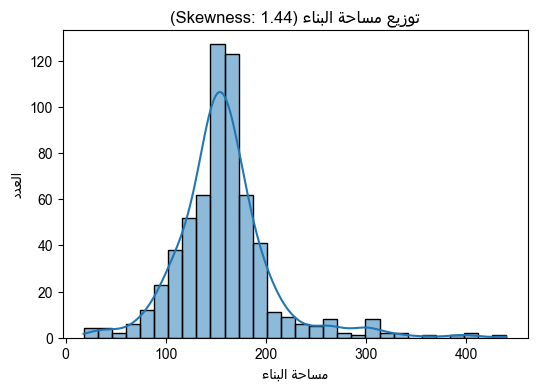

السعر بالشيكل: 5.49


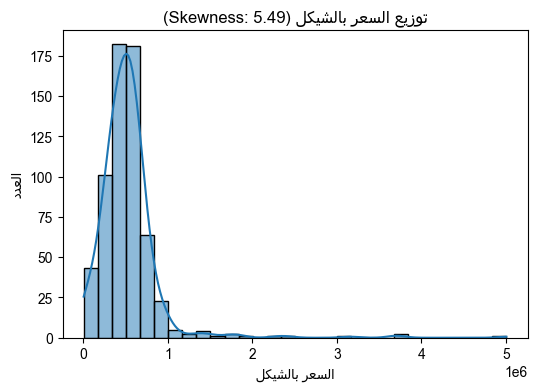

In [11]:
# Select numeric columns
target_cols = ["مساحة البناء", "السعر بالشيكل"]

print("📊 Skewness for Numeric Features:")
for col in target_cols:
    skew_val = df[col].skew()
    print(f"{col}: {skew_val:.2f}")
    
    # Plot histogram + KDE
    plt.figure(figsize=(6, 4))
    sns.histplot(df[col], kde=True, bins=30)
    plt.title(process_arabic_text(f"توزيع {col} (Skewness: {skew_val:.2f})"))
    plt.xlabel(process_arabic_text(col))
    plt.ylabel(process_arabic_text("العدد"))
    plt.show()

We observe that the price distribution is highly right-skewed, so we will apply a power transformation to it.

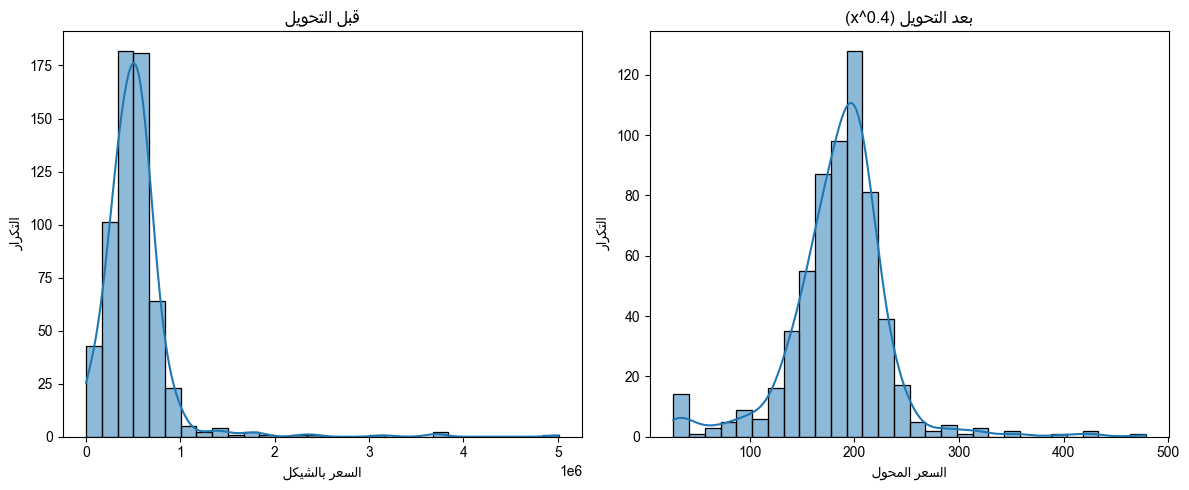

SKEWNESS COMPARISON:
Original skewness: 5.49
Transformed skewness: 0.24
Improvement: 5.25


In [12]:
original_skew = df["السعر بالشيكل"].skew()
df['السعر_الاصلي'] =  df["السعر بالشيكل"].copy()
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.histplot(df["السعر بالشيكل"], kde=True, bins=30)
plt.title(process_arabic_text("قبل التحويل"))
plt.xlabel(process_arabic_text("السعر بالشيكل"))
plt.ylabel(process_arabic_text("التكرار"))

transformed_price = df["السعر بالشيكل"] ** 0.4
plt.subplot(1, 2, 2)
sns.histplot(transformed_price, kde=True, bins=30)
plt.title(process_arabic_text("بعد التحويل (x^0.4)"))
plt.xlabel(process_arabic_text("السعر المحول"))
plt.ylabel(process_arabic_text("التكرار"))

plt.tight_layout()
plt.show()

print("="*50)
print("SKEWNESS COMPARISON:")
print(f"Original skewness: {original_skew:.2f}")
print(f"Transformed skewness: {transformed_price.skew():.2f}")
print(f"Improvement: {original_skew - transformed_price.skew():.2f}")
print("="*50)

df["السعر بالشيكل"] = df["السعر بالشيكل"] ** 0.4

### Relationship Between Target & Numeric Features

In [13]:
features = ["مساحة البناء", "عدد الغرف", "عدد الحمامات", "عمر البناء"]

pearson_corr = df[features + ['السعر بالشيكل']].corr(method='pearson')
spearman_corr = df[features + ['السعر بالشيكل']].corr(method='spearman')

summary = pd.DataFrame({
    'Pearson': pearson_corr['السعر بالشيكل'],
    'Spearman': spearman_corr['السعر بالشيكل']
}).drop('السعر بالشيكل') # Remove self-correlation

summary_sorted = summary.sort_values(by='Spearman', key=abs, ascending=False)


print("\n--- Correlation with Transformed Price ---")
print(summary_sorted.round(3))

features = ["مساحة البناء", "عدد الغرف", "عدد الحمامات", "عمر البناء"]


--- Correlation with Transformed Price ---
              Pearson  Spearman
مساحة البناء    0.372     0.485
عدد الحمامات    0.335     0.430
عدد الغرف       0.068     0.146
عمر البناء     -0.094    -0.139


The correlation results show that area and bathrooms have the strongest relationship with price, so we'll investigate these relationships more closely.

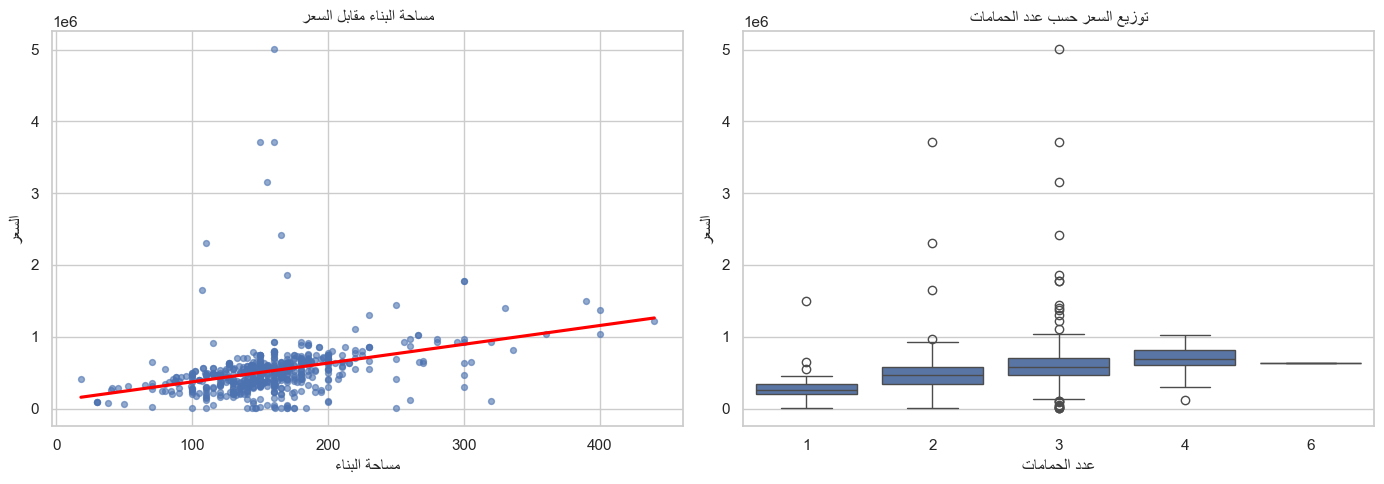

In [14]:
sns.set(style="whitegrid", font_scale=1.0)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

x_area = df['مساحة البناء'].astype(float)
y = df['السعر_الاصلي'].astype(float)

ax1.scatter(x_area, y, s=18, alpha=0.6)
sns.regplot(x=x_area, y=y, scatter=False, ci=None, line_kws={"color":"red"}, ax=ax1)
ax1.set_xlabel(process_arabic_text("مساحة البناء"))
ax1.set_ylabel(process_arabic_text("السعر"))
ax1.set_title(process_arabic_text("مساحة البناء مقابل السعر"))

# Bathrooms box plot (right)
sns.boxplot(x='عدد الحمامات', y='السعر_الاصلي', data=df, ax=ax2)
ax2.set_xlabel(process_arabic_text("عدد الحمامات"))
ax2.set_ylabel(process_arabic_text("السعر"))
ax2.set_title(process_arabic_text("توزيع السعر حسب عدد الحمامات"))

plt.tight_layout()
plt.show()

### Category Counts & Cardinality Check

In [15]:
floor_mapping = {
    'G': 0,  # ارضي
    'B': -1, # شبه ارضي
    'P': -2,  # التسوية
    'R': 11 # Roof
}
df['الطابق'] = df['الطابق'].replace(floor_mapping)

df['الطابق'] = pd.to_numeric(df['الطابق'])


Feature: المدينة
Value counts:
  رام الله والبيرة: 418
  نابلس: 75
  بيت لحم: 37
  طولكرم: 25
  جنين: 20
  الخليل: 18
  القدس: 14
  قلقيلية: 3
  أريحا: 3
  طوباس: 1
  غزة: 1

Total unique values: 11
Most common: رام الله والبيرة (418 occurrences)
Least common: غزة (1 occurrences)


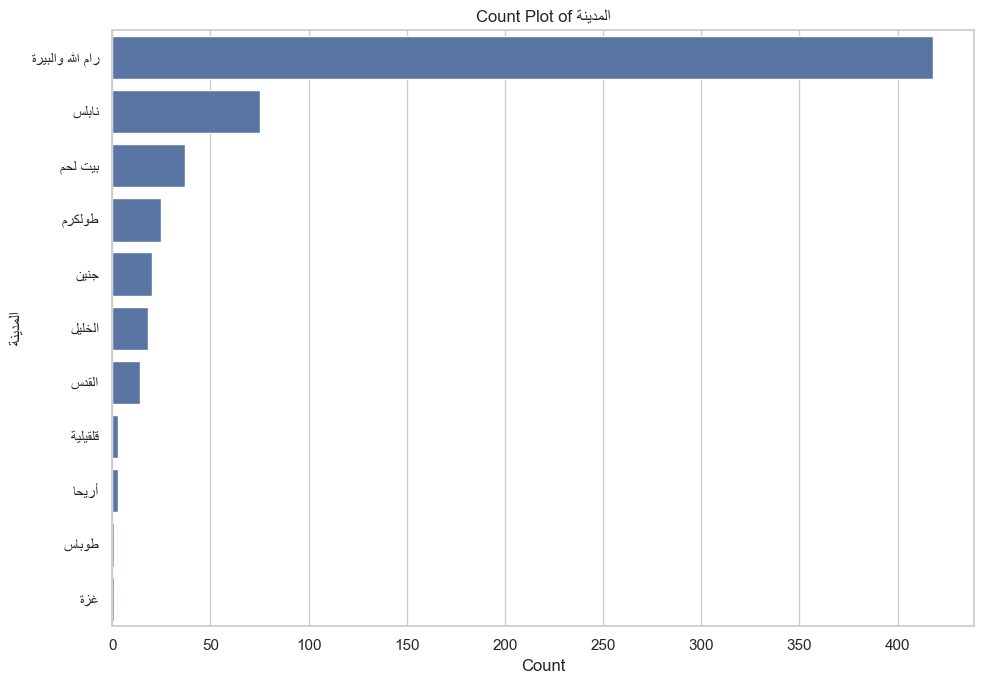


Feature: الحي / المنطقة
Value counts:
  الطيرة: 78
  بيتونيا: 48
  البالوع: 41
  الماصيون: 30
  عين مصباح: 29
  أخرى: 28
  ش. الارسال: 26
  عين منجد: 23
  سطح مرحبا: 17
  سردا: 15
  ضاحية الريحان: 15
  بير زيت: 14
  رفيديا: 13
  ام الشرايط: 11
  بيت جالا: 10
  الجبل الشمالي: 10
  بطن الهوى: 8
  الدوحة: 8
  التحتا: 8
  المخفية: 7
  ش. القدس: 7
  روابي: 6
  بيت ساحور: 6
  الجبل الجنوبي: 6
  الشرفة: 5
  بيت ايبا: 5
  وسط البلد: 5
  الحي الجنوبي: 5
  كفر عقب: 4
  بيت وزن: 4
  ش. التعاون: 4
  الحرس: 4
  ابو ديس: 4
  الجابريات: 4
  شويكة: 4
  الحي الشرقي: 3
  الخضر: 3
  الجامعة الامريكية: 3
  راس الجوزة: 3
  حي المعاجين: 3
  نابلس الجديدة: 3
  الحي الشمالي: 3
  صانور: 3
  ش. نابلس: 3
  ش. عمان: 3
  دار صلاح: 3
  ش. حيفا: 3
  بلعا: 2
  ش. جامعة النجاح: 2
  جبل هندازة: 2
  ش. تل: 2
  ذنابة: 2
  مخيم الجلزون: 1
  النصارية: 1
  المرج: 1
  قوصين: 1
  كفر زيباد: 1
  عقبة تفوح: 1
  الباذان: 1
  جفنا: 1
  المنارة: 1
  حي الجامعة: 1
  صوريف: 1
  الطيبة: 1
  الحاووز الثاني: 1
  جناتا: 1
  ارتاح: 1
  

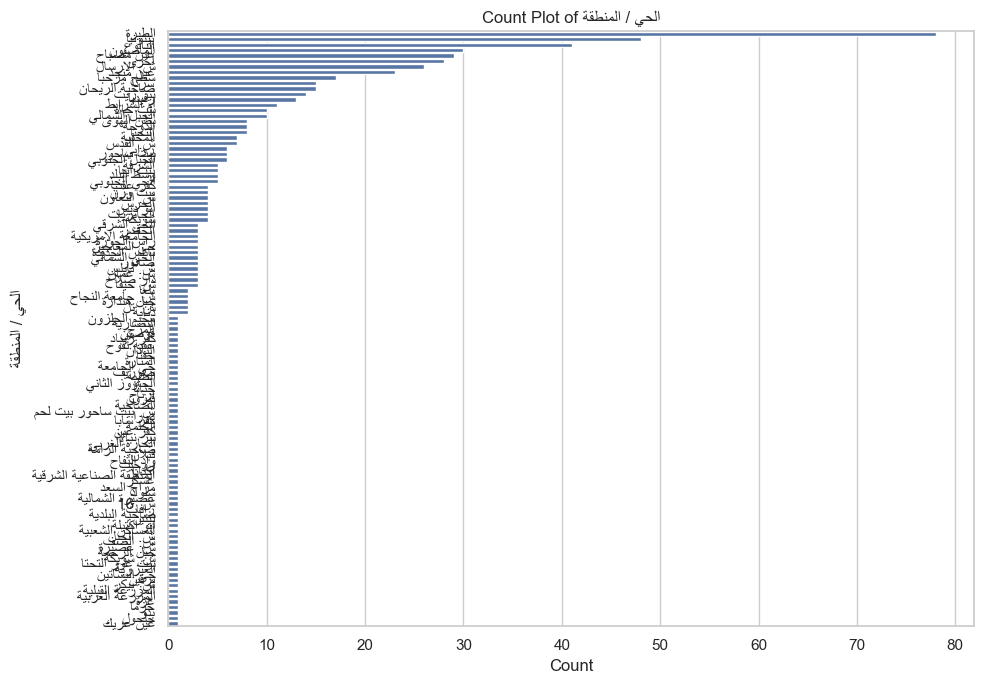


Feature: مفروشة
Value counts:
  0: 503
  1: 85
  2: 27

Total unique values: 3
Most common: 0 (503 occurrences)
Least common: 2 (27 occurrences)


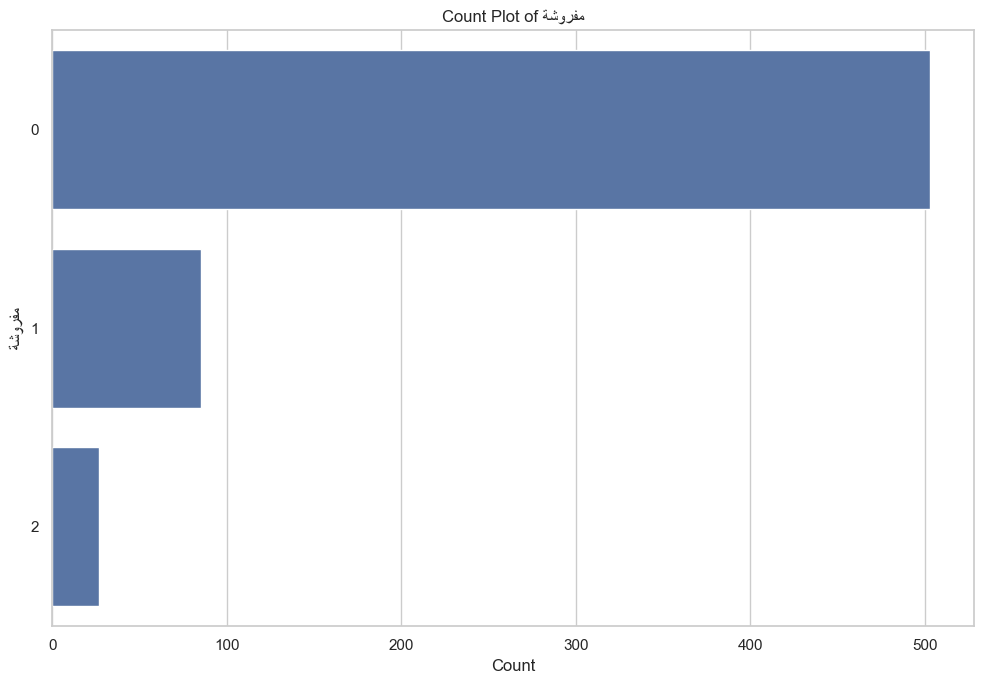


Feature: العقار مرهون
Value counts:
  False: 596
  True: 19

Total unique values: 2
Most common: False (596 occurrences)
Least common: True (19 occurrences)


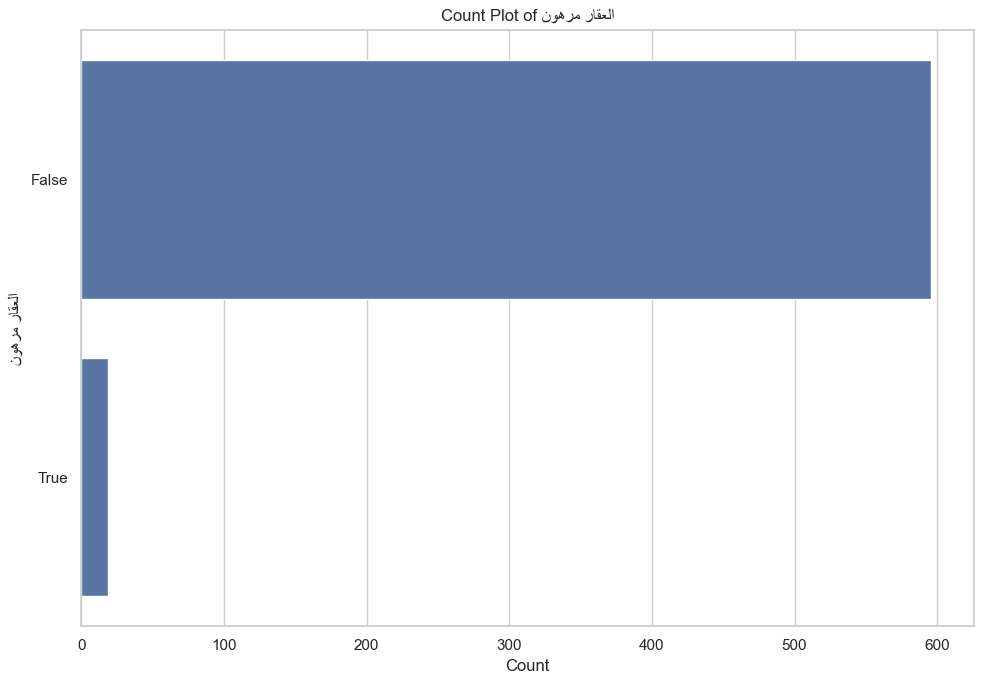


Feature: مصعد
Value counts:
  True: 502
  False: 113

Total unique values: 2
Most common: True (502 occurrences)
Least common: False (113 occurrences)


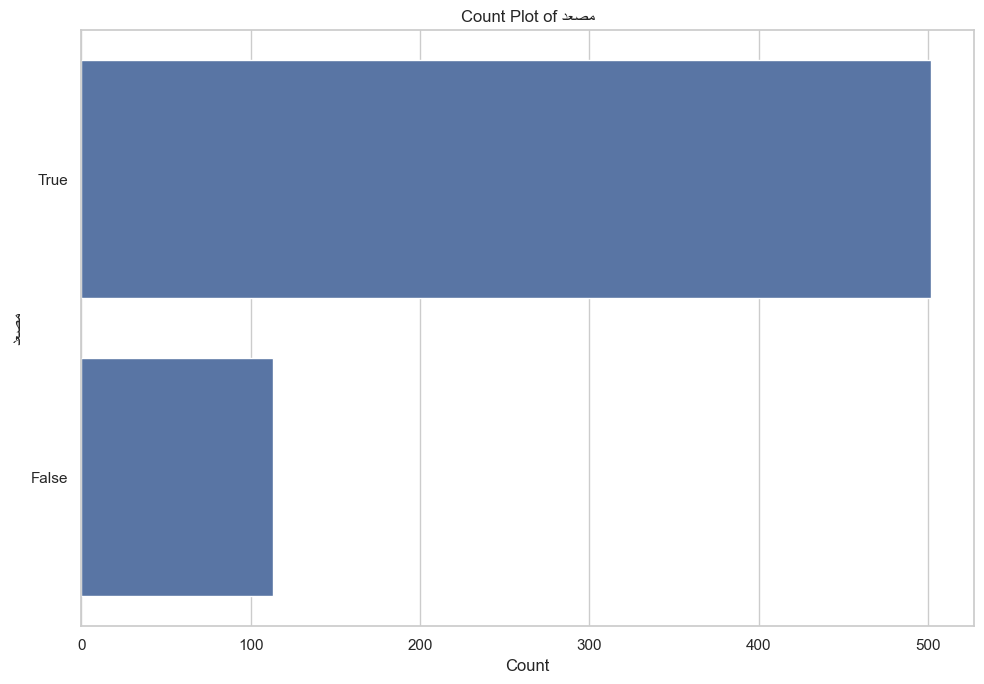


Feature: موقف سيارات
Value counts:
  True: 492
  False: 123

Total unique values: 2
Most common: True (492 occurrences)
Least common: False (123 occurrences)


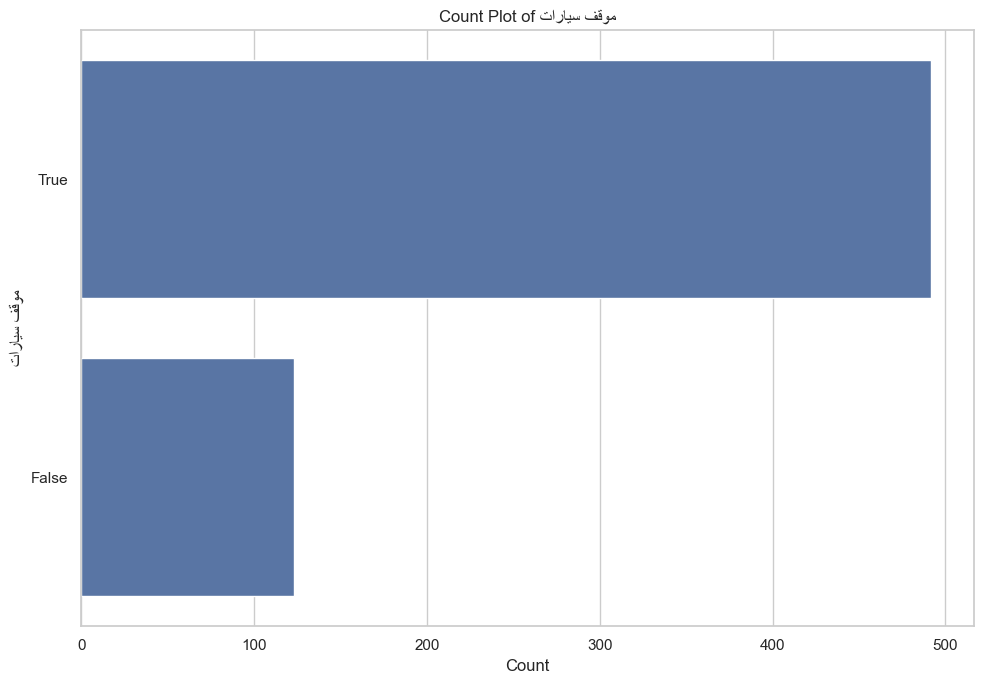


Feature: الطابق
Value counts:
  4: 137
  3: 127
  1: 106
  2: 87
  0: 66
  -1: 30
  6: 20
  11: 16
  -2: 12
  7: 4
  8: 4
  10: 3
  9: 3

Total unique values: 13
Most common: 4 (137 occurrences)
Least common: 9 (3 occurrences)


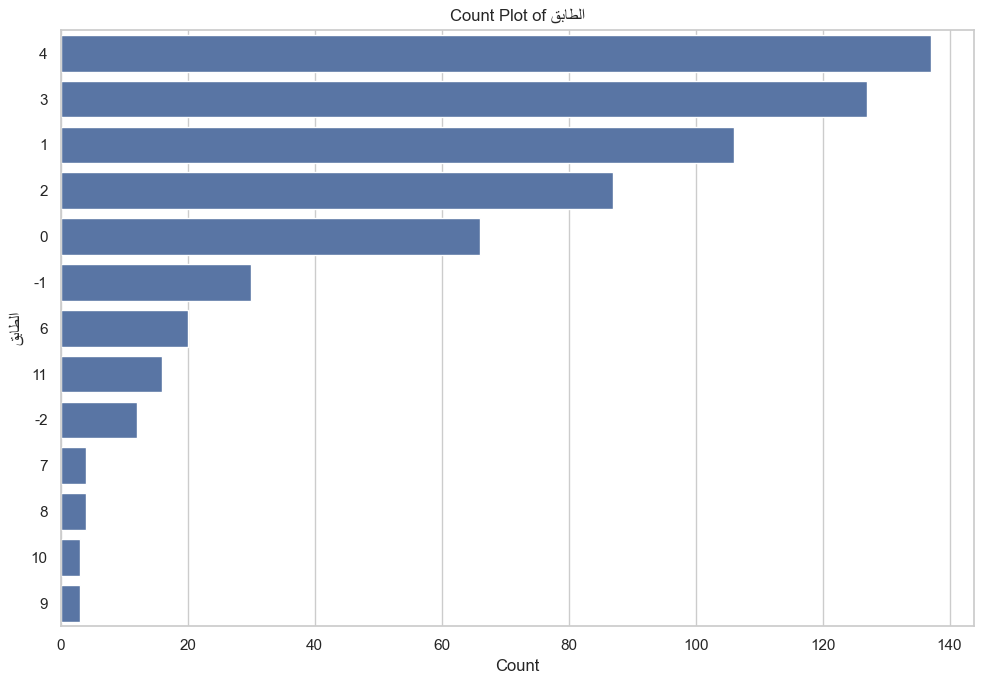

In [16]:
# Manually define the list of categorical features including the newly corrected ones
categorical_features = ['المدينة', 'الحي / المنطقة', 'مفروشة', 'العقار مرهون', 'مصعد', 'موقف سيارات', 'الطابق']

# Create count plots for each of these features
for feature in categorical_features:
    print(f"\n{'='*50}")
    print(f"Feature: {feature}")
    print(f"{'='*50}")
    
    # Use value_counts() to get both the feature values and their counts, then sort by count
    counts = df[feature].value_counts()
    
    print("Value counts:")
    for value, count in counts.items():
        print(f"  {value}: {count}")
    
    print(f"\nTotal unique values: {len(counts)}")
    print(f"Most common: {counts.index[0]} ({counts.iloc[0]} occurrences)")
    print(f"Least common: {counts.index[-1]} ({counts.iloc[-1]} occurrences)")
    
    plt.figure(figsize=(10, 7))
    
    # Process labels for correct Arabic display (only for plots)
    labels = [process_arabic_text(str(label)) for label in counts.index]
    
    sns.barplot(y=counts.index.astype(str), x=counts.values, orient='h', order=counts.index.astype(str))
    
    plt.title(f'Count Plot of {process_arabic_text(feature)}')
    plt.xlabel('Count')
    plt.ylabel(process_arabic_text(feature))
    plt.yticks(plt.gca().get_yticks(), labels) # Set custom labels for y-axis
    plt.tight_layout()
    plt.show()

The categorical analysis shows that the dataset is highly imbalanced across cities, with Ramallah & Al-Bireh dominating and several cities having very few listings, confirming the need for targeted data augmentation for under-represented cities. The neighborhood feature has excessive cardinality (109 unique values, most appearing only once) and will be dropped to reduce noise. Other categorical features such as furnishing status, mortgage status, elevator, and parking are clean, low-cardinality, and ready for encoding. The floor variable has a reasonable distribution and will be treated as an ordered categorical feature to capture its potential non-linear effect on price.

In [17]:
# Drop the 'الحي / المنطقة' column from the dataframe
df.drop('الحي / المنطقة', axis=1, inplace=True)

### Price Relationship with Categorical Features

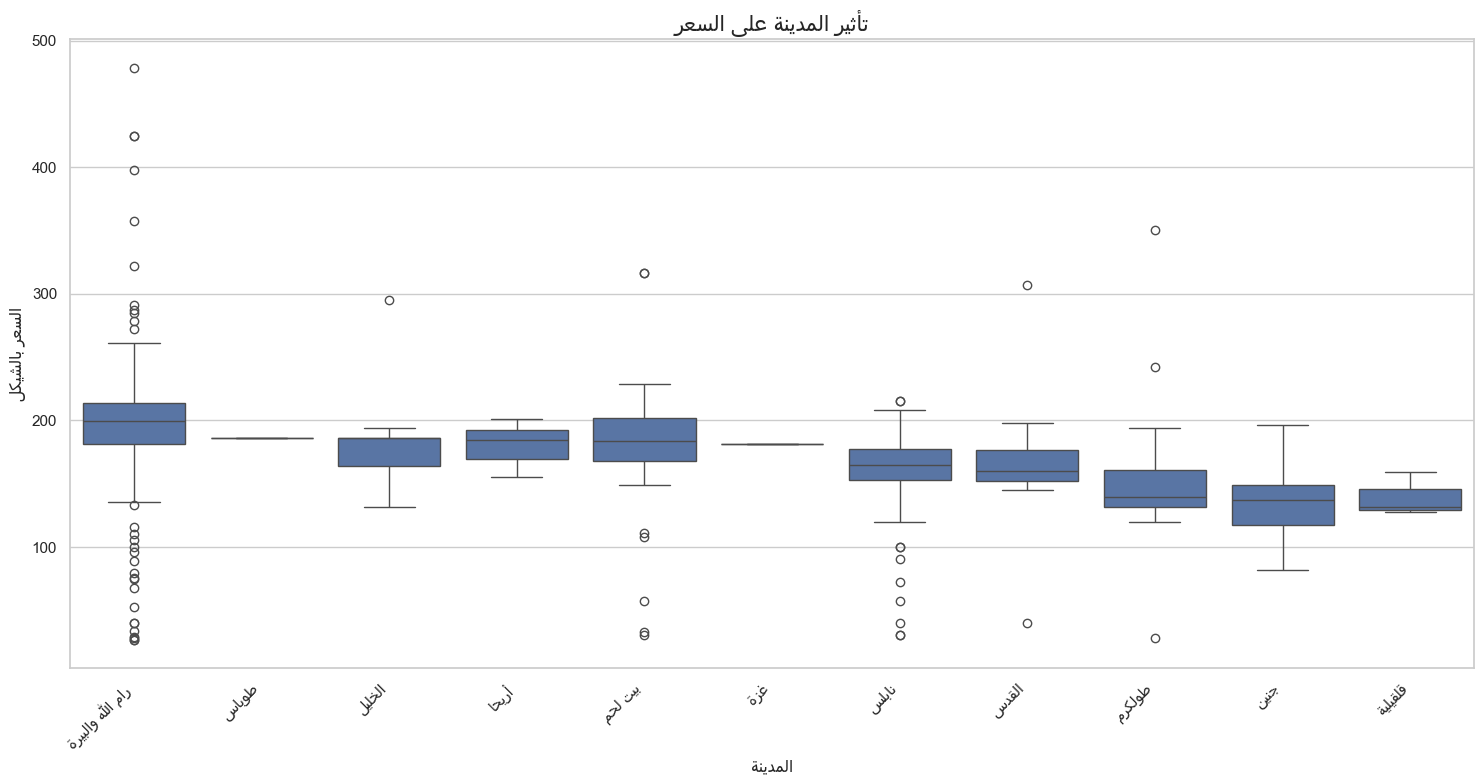

In [18]:
# Set plot style
sns.set_style("whitegrid")
plt.rcParams['font.family'] = 'Arial Unicode MS' # Ensure font is set for Arabic

# Box plot for City vs. Price
plt.figure(figsize=(15, 8))

# Order the cities by their median price for a cleaner plot
city_order = df.groupby('المدينة')['السعر بالشيكل'].median().sort_values(ascending=False).index
processed_labels = [process_arabic_text(label) for label in city_order]

sns.boxplot(data=df, x='المدينة', y='السعر بالشيكل', order=city_order)

plt.title(process_arabic_text('تأثير المدينة على السعر'), fontsize=16)
plt.xlabel(process_arabic_text('المدينة'), fontsize=12)
plt.ylabel(process_arabic_text('السعر بالشيكل'), fontsize=12)
plt.xticks(ticks=range(len(processed_labels)), labels=processed_labels, rotation=45, ha='right')
plt.tight_layout()
plt.show()

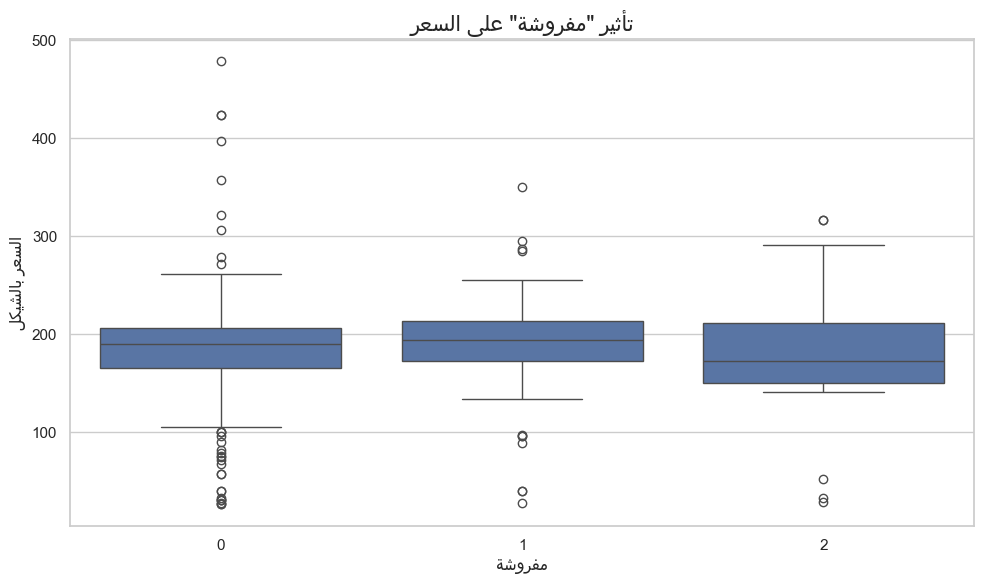

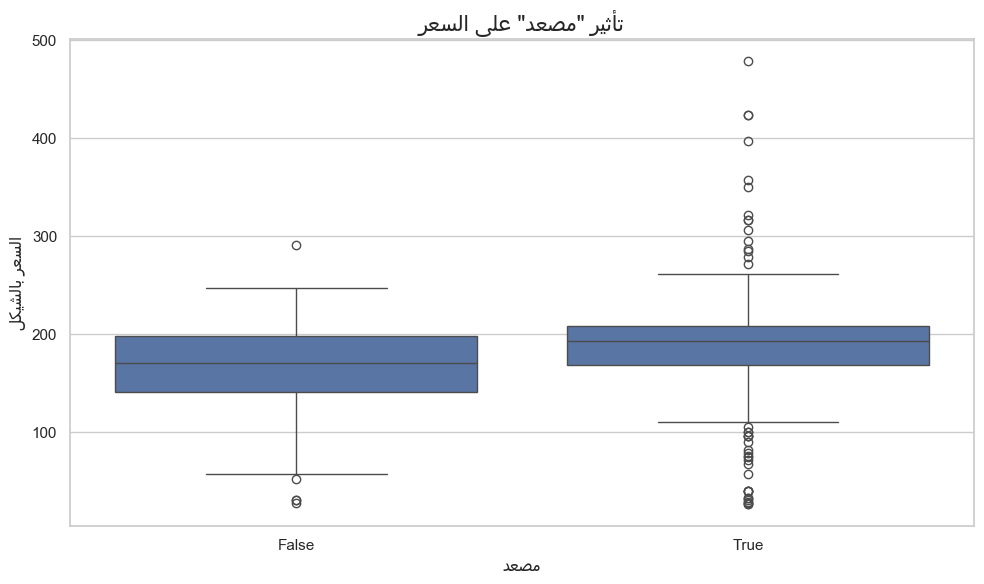

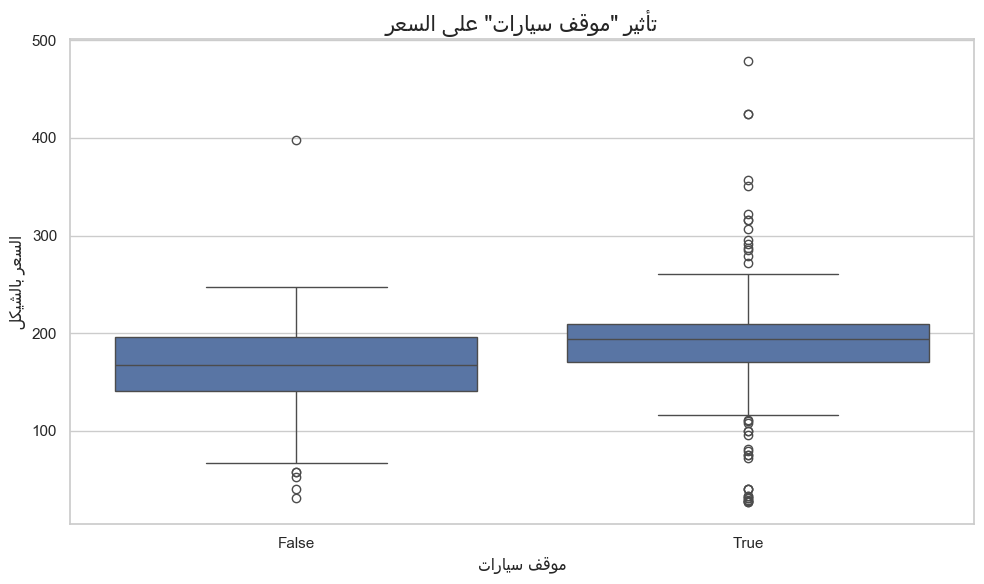

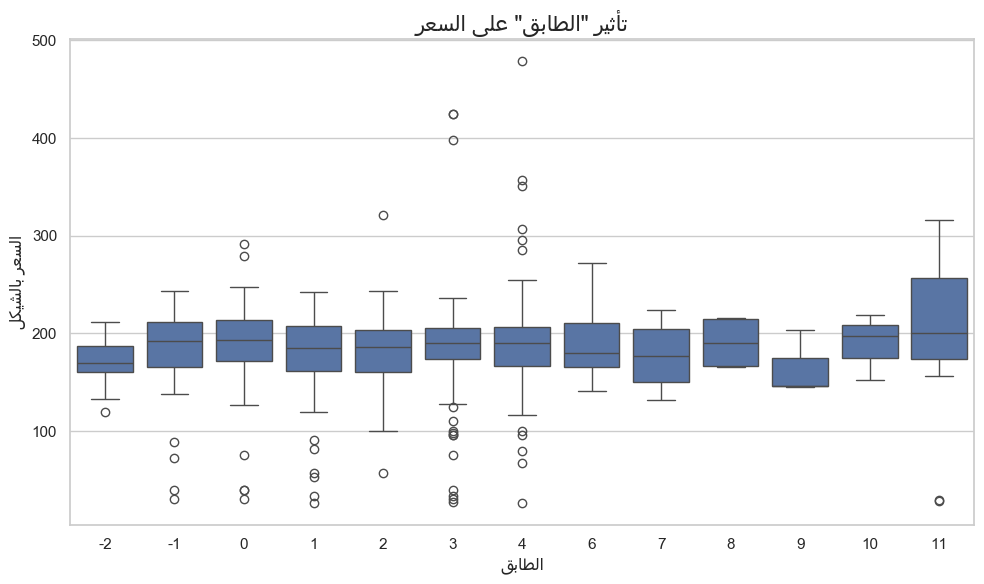

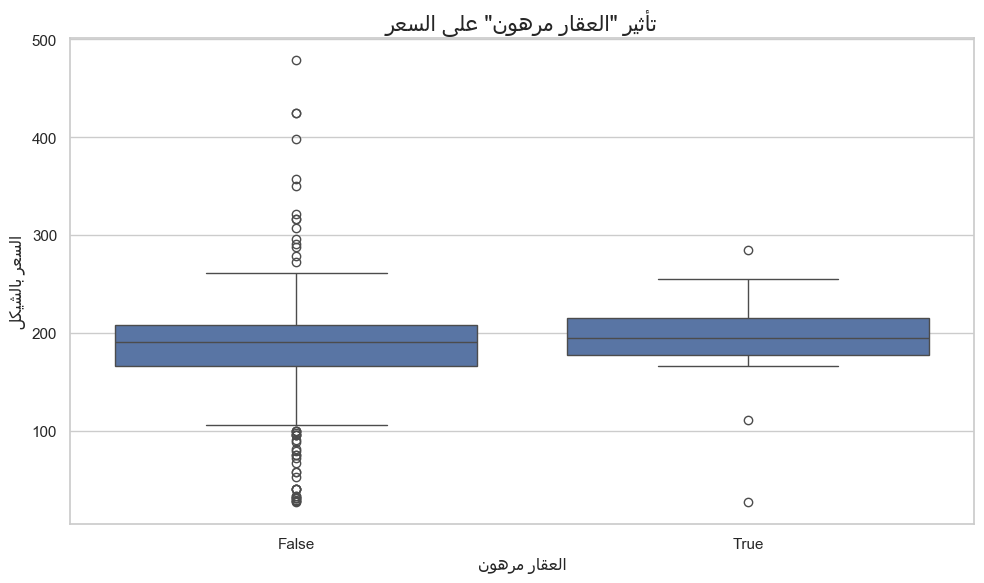

In [19]:
# Define the other categorical features we decided to keep
other_categorical_features = ['مفروشة', 'مصعد', 'موقف سيارات', 'الطابق', 'العقار مرهون']

# Generate a box plot for each feature against the price
for feature in other_categorical_features:
    plt.figure(figsize=(10, 6))
    
    # For 'الطابق' (Floor), it's better to sort the x-axis numerically
    order = sorted(df[feature].unique()) if feature == 'الطابق' else None
    
    sns.boxplot(data=df, x=feature, y='السعر بالشيكل', order=order)
    
    # Create titles and labels
    title_text = process_arabic_text(f'تأثير "{feature}" على السعر')
    xlabel_text = process_arabic_text(feature)
    ylabel_text = process_arabic_text('السعر بالشيكل')
    
    plt.title(title_text, fontsize=16)
    plt.xlabel(xlabel_text, fontsize=12)
    plt.ylabel(ylabel_text, fontsize=12)
    plt.tight_layout()
    plt.show()

Based on our feature analysis, we've identified significant class imbalance in the city distribution. To address this in our modeling phase, we will implement:
- Bootstrap Sampling: Oversample properties from underrepresented cities to ensure adequate training representation.
- Gaussian Noise Augmentation: Add controlled variations to continuous features when duplicating samples to create realistic diversity while preserving the data relationships observed in our correlation analysis.
These techniques will help our model generalize better across all cities while maintaining the key feature relationships, particularly the strong correlations between area, bathrooms, and price.

In [20]:
df.to_csv('Apts_Updated')